In [53]:
# Import the Earth Engine package, installing it first, if needed.
try:
    import ee
except ModuleNotFoundError:
    !pip install earthengine-api
    import ee
    

In [54]:
import pprint
from IPython.display import Image

In [55]:
# Import the SSEBop package, installing it first, if needed.
try:
    import openet.ssebop as model
    print('worked')
except ModuleNotFoundError:
    !pip install openet-ssebop
    import openet.ssebop as model

worked


In [56]:
try:
    ee.Initialize()
    print('worked')
except ee.EEException:
    print('trying a second time')
    ee.Authenticate()
    ee.Initialize()

worked


In [57]:
ndvi_palette = ['#EFE7E1', '#003300']
et_palette = [
    'DEC29B', 'E6CDA1', 'EDD9A6', 'F5E4A9', 'FFF4AD', 'C3E683', '6BCC5C', 
    '3BB369', '20998F', '1C8691', '16678A', '114982', '0B2C7A']
viridis_palette = ['440154', '433982', '30678D', '218F8B', '36B677', '8ED542', 'FDE725']


image_size = 768

In [58]:
# Salinas
# landsat_img = ee.Image('LANDSAT/LC08/C02/T1_L2/LC08_043035_20160722')
# Wilcox
# landsat_img = ee.Image('LANDSAT/LC08/C02/T1_L2/LC08_035037_20160714')
# Viginia
# landsat_img = ee.Image('LANDSAT/LC08/C02/T1_L2/LC08_016033_20160725')
x = 'LC08_016033_20160725'
landsat_img = ee.Image(f'LANDSAT/LC08/C02/T1_L2/{x}')
landsat_crs = landsat_img.select('SR_B3').projection().getInfo()['crs']
landsat_region = landsat_img.geometry().bounds(1, 'EPSG:4326')
landsat_dt = ee.Date(landsat_img.get('system:time_start'))

In [59]:
image_name_dict = {'LC08_043035_20160722': 'Salinas_CA', 'LC08_035037_20160714':'Wilcox_AZ', 'LC08_016033_20160725': 'Woodstock_VA'}

In [60]:
# Build the SSEBop object from the Landsat image

# ### ============== Lapse Rate Adjusted =================
# model_obj = model.Image.from_landsat_c2_sr(
#     landsat_img, 
#     tcorr_source='SCENE_GRIDDED',
# #     tcorr_source='projects/earthengine-legacy/assets/projects/usgs-ssebop/tcorr_gridded/c02/daymet_v4_mean_1981_2010_elr',
#     et_reference_source='IDAHO_EPSCOR/GRIDMET', 
#     et_reference_band='etr', 
#     et_reference_factor=0.85,
#     et_reference_resample='nearest',
#     tmax_source='projects/usgs-ssebop/tmax/daymet_v4_mean_1981_2010_elr'
# )

## ============== NON-Lapse Rate Adjusted =================
# Build the SSEBop object from the Landsat image
model_obj = model.Image.from_landsat_c2_sr(
    landsat_img, 
    tcorr_source='SCENE_GRIDDED',
    et_reference_source='IDAHO_EPSCOR/GRIDMET', 
    et_reference_band='etr', 
    et_reference_factor=0.85,
    et_reference_resample='nearest',
    tmax_source='projects/usgs-ssebop/tmax/daymet_v4_mean_1981_2010'
)


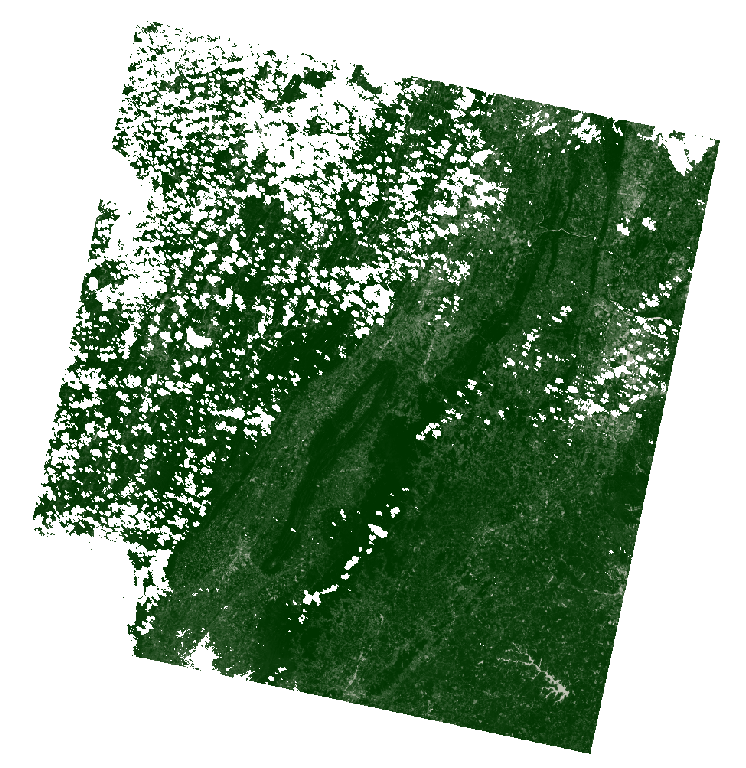

In [61]:
image_url = model_obj.ndvi\
    .getThumbURL({'min': -0.1, 'max': 0.9, 'palette': ndvi_palette, 
                  'region': landsat_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

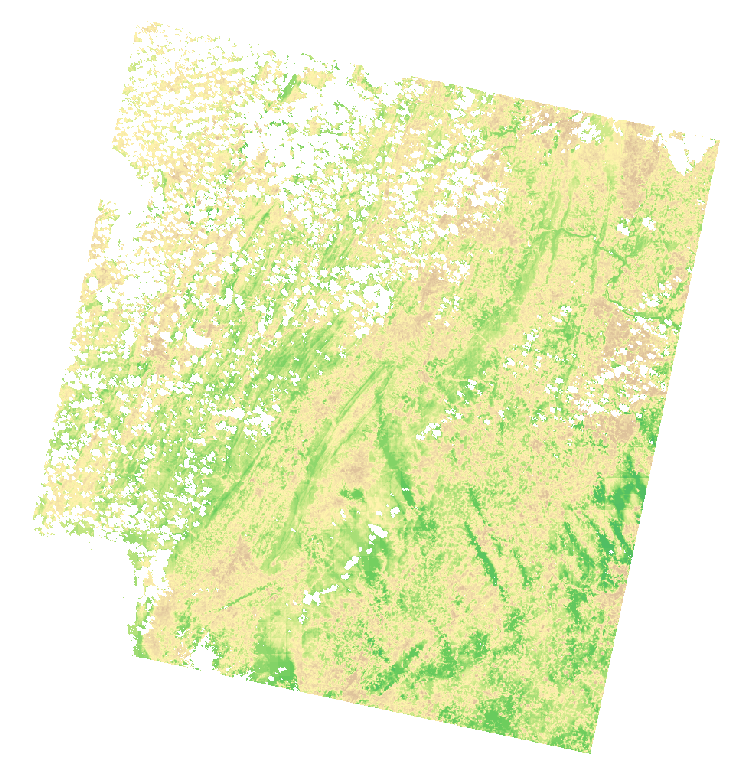

In [62]:
image_url = model_obj.et\
    .getThumbURL({'min': 0.0, 'max': 15, 'palette': et_palette, 
                  'region': landsat_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

In [63]:
def ee_task_start(task, n=10):
    """Make an exponential backoff Earth Engine request"""
    output = None
    for i in range(1, n):
        try:
            task.start()
            break
        except Exception as e:
            time.sleep(i ** 2)
    return task

In [64]:
task = ee.batch.Export.image.toAsset(image=model_obj.et , description=f'ET_{image_name_dict[x]}_{x}', assetId=f'users/gbrlparrish/grid_c_march_II_coll2/ET_{image_name_dict[x]}_{x}_daymet_v4_mean_1981_2010', region=landsat_region)
print(f'starting ET export {image_name_dict[x]}_{x}')
ee_task_start(task=task)
print('task submitted')

starting ET export Woodstock_VA_LC08_016033_20160725
task submitted


In [65]:
## output the ET image
# Export.image.toAsset(model_obj.et, f'{image_name_dict[x]}_{x}', assetId=f'users/gbrlparrish/grid_c_march_II_coll2/ET_{image_name_dict[x]}_{x}', region=landsat_region)